# Applied Physics Lab - III. Liquid Scintillation Spectroscopy @ ELTE

In [28]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

In [29]:
# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

In [30]:
PC = True
if PC:
    FSS_dir = 'D://GitHub/ELTE_Applied_Physics_2019/III. Liquid Scintillation Spectroscopy/'
    FSS_data = FSS_dir + 'data/'
    figsave_dir = FSS_dir + 'Documentation/report/src/images/'
else:
    FSS_dir = 'C://Users/masterdesky/Documents/GitHub/ELTE_Applied_Physics_2019/III. Liquid Scintillation Spectroscopy/'
    FSS_data = FSS_dir + 'data/'
    figsave_dir = FSS_dir + 'Documentation/report/src/images/'

figsave_format = 'pdf'
figsave_dpi = 200
    
# Bold print
b1 = '\033[1m'
b0 = '\033[0m'

### $^{14}$C data

In [31]:
Z = 6
# Q-value [keV]
Q = 156.5
DPM = 120900

In [32]:
# mass of electron [kg]
m_e = 9.10938356e-31
# light speed [m/s]
c_light = 299792458
# 1 J = 6.2415096471204 * 10^{15} keV
J_to_keV = 6.2415096471204e15

print(b1 + 'm*c^2 = ' + b0 + '{0} keV'.format(m_e*c_light**2 * J_to_keV))

m*c^2 = 510.99898894284576 keV


## Import data

In [33]:
os.listdir(FSS_data)

['fss_20191010.log',
 'fss_20191010a_1.dat',
 'fss_20191010a_2.dat',
 'fss_20191010a_3.dat',
 'tridat_20191010.log',
 'tridat_20191010a.log']

In [34]:
def read_data_files(file):
    
    bins = {}
    
    with open(file, mode='rt') as f:
        for line in f:

            # Dataline format:
            # "bin;v;v;v;..."
            # 
            s = line.split(';')
            # The first element will contain the bin label, while
            # the other elements contains the bin values
            # s[0] == bin
            # s[i != 0] == values
            s[0] = s[0].replace(',', '.')
            bins[float(s[0])-0.25] = [int(x) for x in s[1:]]

    # Convert to pandas DataFrame
    df = pd.DataFrame(data=bins)
    
    return df

In [35]:
data_1 = read_data_files(file=(FSS_data + os.listdir(FSS_data)[1]))
data_2 = read_data_files(file=(FSS_data + os.listdir(FSS_data)[2]))
data_3 = read_data_files(file=(FSS_data + os.listdir(FSS_data)[3]))
data = data_1.append(data_2, ignore_index=True).append(data_3, ignore_index=True)
data = data.T

In [36]:
data

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0.25,15,32,25,25,19,23,16,15,30,20,...,25,20,15,14,1439,17,17,22,30,30
0.75,149,139,134,121,143,137,145,123,123,150,...,137,138,150,118,1371,129,136,140,110,135
1.25,484,449,489,452,466,483,492,508,485,489,...,465,450,426,457,1450,483,490,435,457,482
1.75,776,755,774,783,768,754,789,757,749,793,...,780,748,780,786,1384,748,776,834,742,792
2.25,944,964,963,982,1001,992,985,1003,987,1027,...,956,975,1024,957,1432,958,1001,976,1000,975
2.75,1109,1129,1081,1133,1164,1140,1133,1161,1080,1124,...,1107,1091,1123,1147,1467,1123,1138,1098,1112,1137
3.25,1237,1259,1286,1320,1208,1270,1256,1232,1237,1167,...,1241,1268,1265,1245,1417,1191,1220,1172,1257,1320
3.75,1358,1260,1278,1315,1270,1280,1304,1330,1245,1301,...,1297,1332,1338,1325,1393,1305,1267,1331,1321,1295
4.25,1319,1346,1380,1367,1378,1394,1338,1410,1232,1333,...,1334,1299,1375,1279,1431,1373,1359,1322,1332,1388
4.75,1425,1329,1447,1427,1412,1325,1398,1360,1392,1306,...,1452,1421,1371,1423,1449,1296,1287,1331,1352,1383


### Drop errorous measurements

In [37]:
for i in np.where(data.iloc[0].values > 100)[0]:
    del data[i]

data.columns = [i for i in range(len(data.columns.values))]

In [38]:
data

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0.25,15,32,25,25,19,23,16,15,30,20,...,16,25,20,15,14,17,17,22,30,30
0.75,149,139,134,121,143,137,145,123,123,150,...,142,137,138,150,118,129,136,140,110,135
1.25,484,449,489,452,466,483,492,508,485,489,...,462,465,450,426,457,483,490,435,457,482
1.75,776,755,774,783,768,754,789,757,749,793,...,821,780,748,780,786,748,776,834,742,792
2.25,944,964,963,982,1001,992,985,1003,987,1027,...,964,956,975,1024,957,958,1001,976,1000,975
2.75,1109,1129,1081,1133,1164,1140,1133,1161,1080,1124,...,1113,1107,1091,1123,1147,1123,1138,1098,1112,1137
3.25,1237,1259,1286,1320,1208,1270,1256,1232,1237,1167,...,1207,1241,1268,1265,1245,1191,1220,1172,1257,1320
3.75,1358,1260,1278,1315,1270,1280,1304,1330,1245,1301,...,1318,1297,1332,1338,1325,1305,1267,1331,1321,1295
4.25,1319,1346,1380,1367,1378,1394,1338,1410,1232,1333,...,1318,1334,1299,1375,1279,1373,1359,1322,1332,1388
4.75,1425,1329,1447,1427,1412,1325,1398,1360,1392,1306,...,1434,1452,1421,1371,1423,1296,1287,1331,1352,1383


### Calculate statistical data columns

In [39]:
data['mean'] = [np.mean(data.iloc[i]) for i in range(len(data.index))]
data['std'] = [np.std(data.iloc[i]) for i in range(len(data.index))]

In [40]:
data

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,mean,std
0.25,15,32,25,25,19,23,16,15,30,20,...,20,15,14,17,17,22,30,30,20.122449,4.645999
0.75,149,139,134,121,143,137,145,123,123,150,...,138,150,118,129,136,140,110,135,137.877551,12.380037
1.25,484,449,489,452,466,483,492,508,485,489,...,450,426,457,483,490,435,457,482,467.571429,21.241469
1.75,776,755,774,783,768,754,789,757,749,793,...,748,780,786,748,776,834,742,792,777.285714,28.412673
2.25,944,964,963,982,1001,992,985,1003,987,1027,...,975,1024,957,958,1001,976,1000,975,980.755102,32.179205
2.75,1109,1129,1081,1133,1164,1140,1133,1161,1080,1124,...,1091,1123,1147,1123,1138,1098,1112,1137,1126.673469,24.451084
3.25,1237,1259,1286,1320,1208,1270,1256,1232,1237,1167,...,1268,1265,1245,1191,1220,1172,1257,1320,1237.857143,37.436346
3.75,1358,1260,1278,1315,1270,1280,1304,1330,1245,1301,...,1332,1338,1325,1305,1267,1331,1321,1295,1310.571429,29.197945
4.25,1319,1346,1380,1367,1378,1394,1338,1410,1232,1333,...,1299,1375,1279,1373,1359,1322,1332,1388,1345.346939,40.162944
4.75,1425,1329,1447,1427,1412,1325,1398,1360,1392,1306,...,1421,1371,1423,1296,1287,1331,1352,1383,1380.510204,44.268328


## Plot spectrums

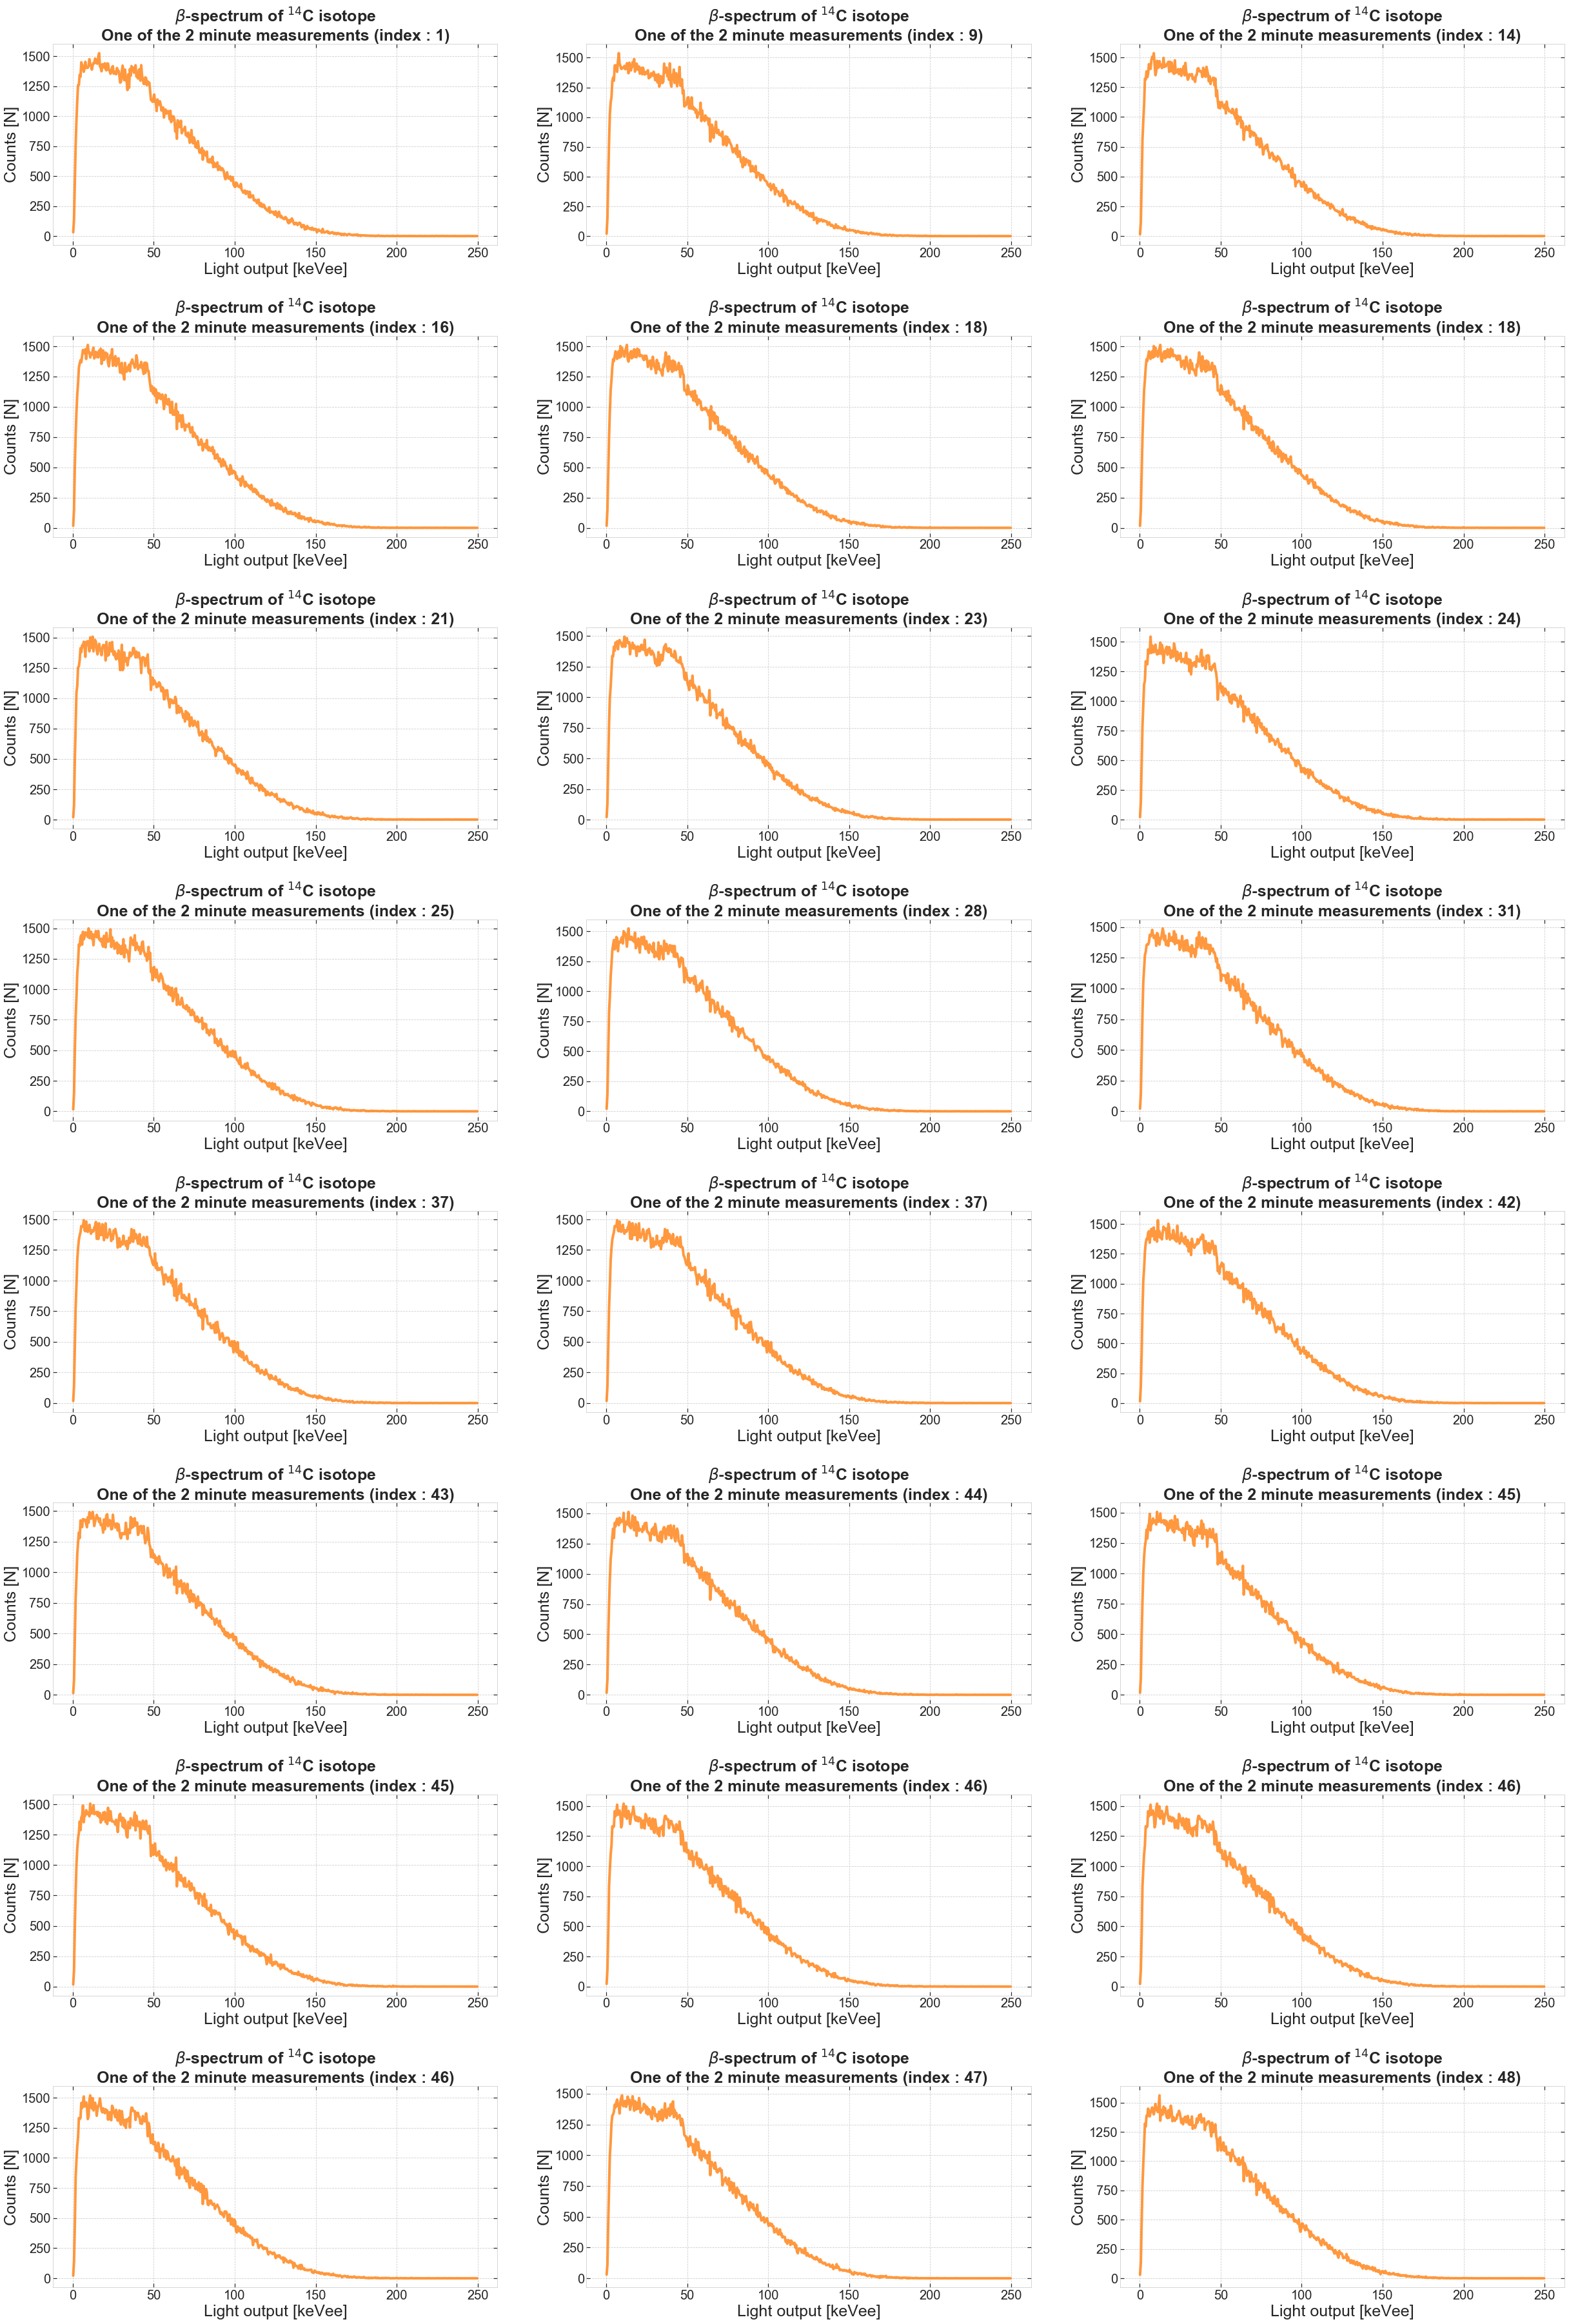

In [14]:
nrows = 8
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14,nrows*8))
fig.subplots_adjust(hspace=0.45)

titlesize = 25
axislabelsize = 25
axisticksize = 20

random_indeces = np.random.randint(low=0, high=(len(data.columns)-2), size=nrows*ncols)
random_indeces = sorted(random_indeces)
for i in range(nrows):
    for j in range(ncols):
        axes[i][j].plot(data.index, data[random_indeces[i*ncols + j]],
                        lw=4, color='tab:orange', alpha=0.8)

        axes[i][j].set_title(('$\\beta$-spectrum of $^{14}$C isotope\n' +
                              'One of the 2 minute measurements (index : {0})'.format(random_indeces[i*ncols + j])),
                             fontsize=titlesize, fontweight='bold')
        axes[i][j].set_xlabel('Light output [keVee]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Counts [N]', fontsize=axislabelsize)
        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)

plt.savefig(figsave_dir + 'random_spectrums.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

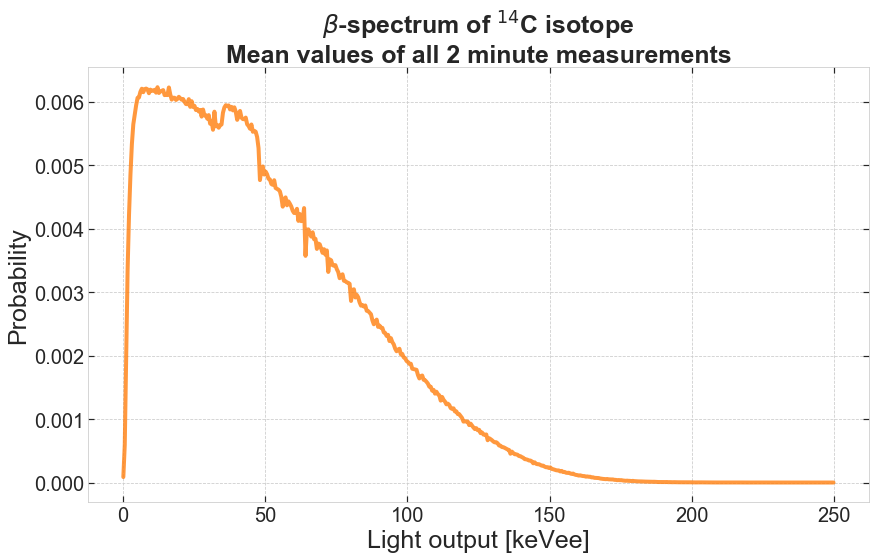

In [15]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14,nrows*8))

titlesize = 25
axislabelsize = 25
axisticksize = 20

axes.plot(data.index, data['mean']/np.sum(data['mean']),
          lw=4, color='tab:orange', alpha=0.8)

axes.set_title('$\\beta$-spectrum of $^{14}$C isotope\nMean values of all 2 minute measurements',
               fontsize=titlesize, fontweight='bold')
axes.set_xlabel('Light output [keVee]', fontsize=axislabelsize)
axes.set_ylabel('Probability', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.savefig(figsave_dir + 'mean_spectrum.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

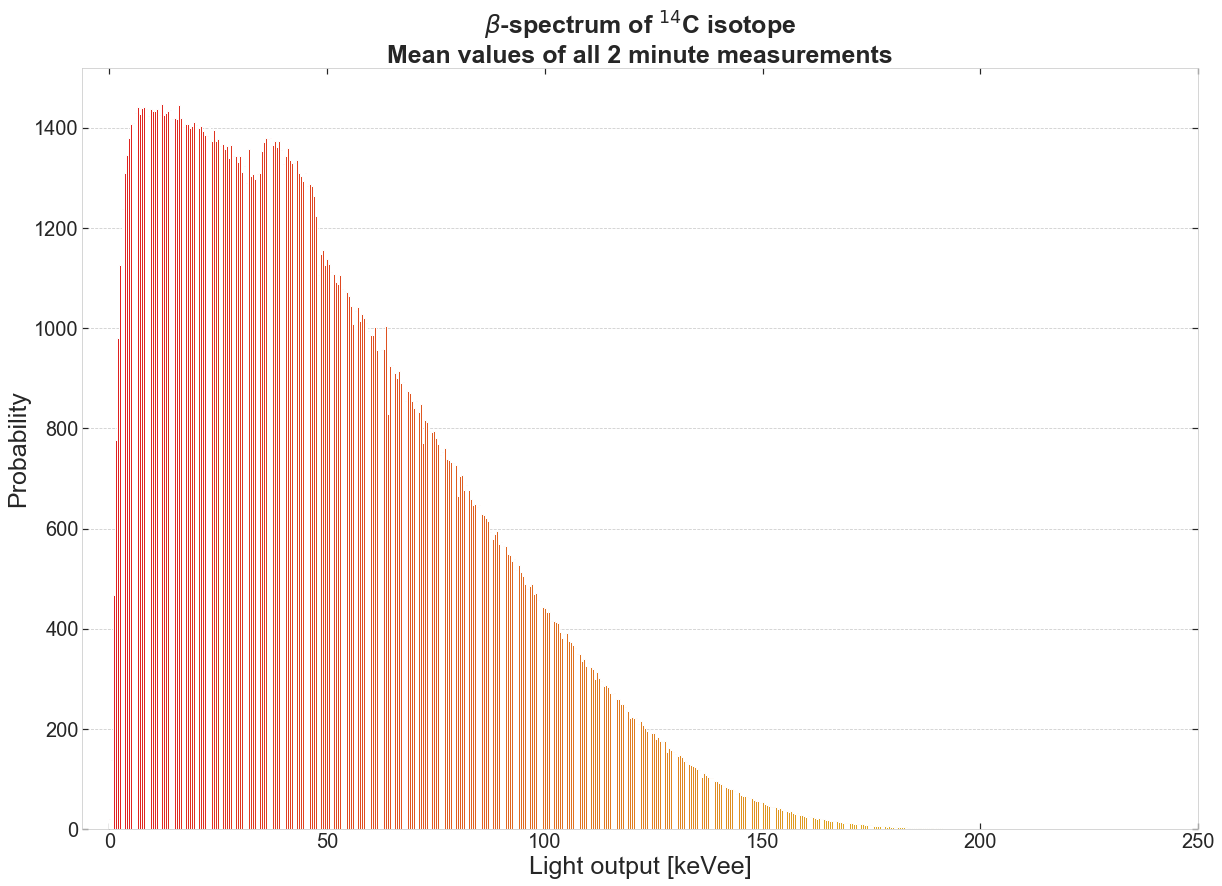

In [16]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*20,nrows*14))

titlesize = 25
axislabelsize = 25
axisticksize = 20

x_lim = (-12.5, 262.5)
x_ticks_loc = axes.get_xticks()
x_ticks_val = [int(x*(np.max(data.index.values)+0.25)) for x in x_ticks_loc]

sns.barplot(data.index, y='mean', data=data,
            palette='autumn', ci=None,
            ax=axes)

#axes.bar(data.index, data['mean']/np.sum(data['mean']),
#         width=0.5, align='center', color='tab:orange', alpha=1.0)

axes.set_xlim(x_lim)
axes.set_xticks(list(np.array(x_ticks_val)*2))
axes.set_xticklabels(x_ticks_val)
axes.set_title('$\\beta$-spectrum of $^{14}$C isotope\nMean values of all 2 minute measurements',
               fontsize=titlesize, fontweight='bold')
axes.set_xlabel('Light output [keVee]', fontsize=axislabelsize)
axes.set_ylabel('Probability', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.savefig(figsave_dir + 'mean_spectrum_binned.' + 'png',
            format='png',
            dpi=300,
            bbox_inches='tight')
plt.show()

### Calculate CPM

In [17]:
CPM = (0.5 * data['mean'].values).sum() / 2
eta = CPM / DPM
print(b1 + 'Measured CPM : ' + b0 + '{0:.0f}'.format(CPM))
print(b1 + 'Measured eta : ' + b0 + '{0:.3f}%'.format(eta*100))

Measured CPM : 58022
Measured eta : 47.991%


### Calculate wheter if $\left< E \right> = \frac{Q}{3}$

In [214]:
E_pred = (data.index.values * data['mean'].values).sum()/data['mean'].sum()
E_grtr = Q/3
diff = np.abs(E_pred - E_grtr)

print(b1 + 'Difference from groundtruth value is ' + b0 + '{0:.2f} %'.format(diff/E_grtr * 100))

Difference from groundtruth value is 4.13 %


In [216]:
E_grtr

52.166666666666664

In [215]:
E_pred

50.0133004857884

### Test wheter if $\sqrt{N} \approx \sigma$

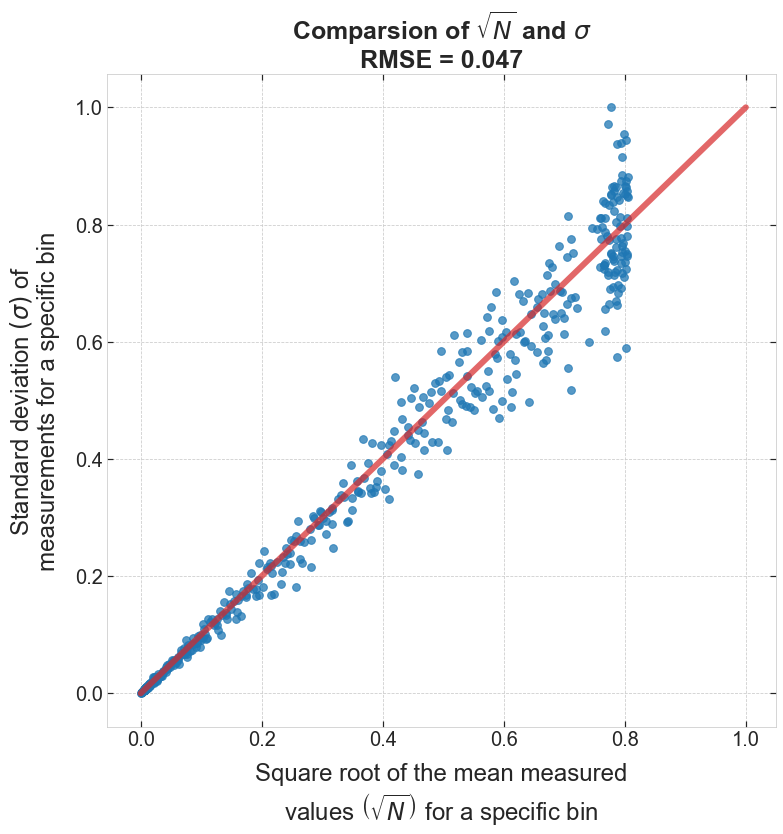

In [19]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*12,nrows*12))

titlesize = 25
axislabelsize = 24
axisticksize = 20
labelpad = 15

std_1 = np.sqrt(data['mean'].values)
std_2 = data['std'].values

norm = np.max([std_1, std_2])

axes.scatter(std_1/norm, std_2/norm,
             color='tab:blue', s=60, alpha=0.75)
axes.plot([0,1],[0,1], color='tab:red', lw=6, alpha=0.7)

rmse = np.sqrt(mean_squared_error(std_1/norm, std_2/norm))

axes.set_title('Comparsion of $\sqrt{N}$ and $\sigma$\n' + 'RMSE = {0:.3f}'.format(rmse),
               fontsize=titlesize, fontweight='bold')
axes.set_xlabel('Square root of the mean measured\nvalues $\\left( \\sqrt{N} \\right)$ for a specific bin',
                fontsize=axislabelsize, labelpad=labelpad)
axes.set_ylabel('Standard deviation $\\left( \\sigma \\right)$ of\nmeasurements for a specific bin',
                fontsize=axislabelsize, labelpad=labelpad)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.savefig(figsave_dir + 'error_compare.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

## Fit theoretical curves on spectrums
### Non-relat without Fermi function

In [164]:
def fit_non_relat(E, A, B, C, D):
    
    return A + B * E**(2/3) - C * E**(5/2) + D * E**(7/2)

In [206]:
energies = data.index
popt_nrel, pcov_nrel = curve_fit(fit_non_relat, energies, data['mean'])
perr_nrel = np.sqrt(np.diag(pcov_nrel))
print(perr_nrel / popt_nrel * 100)

[ 1.96619725 -7.82997961  8.6245835   7.29417939]


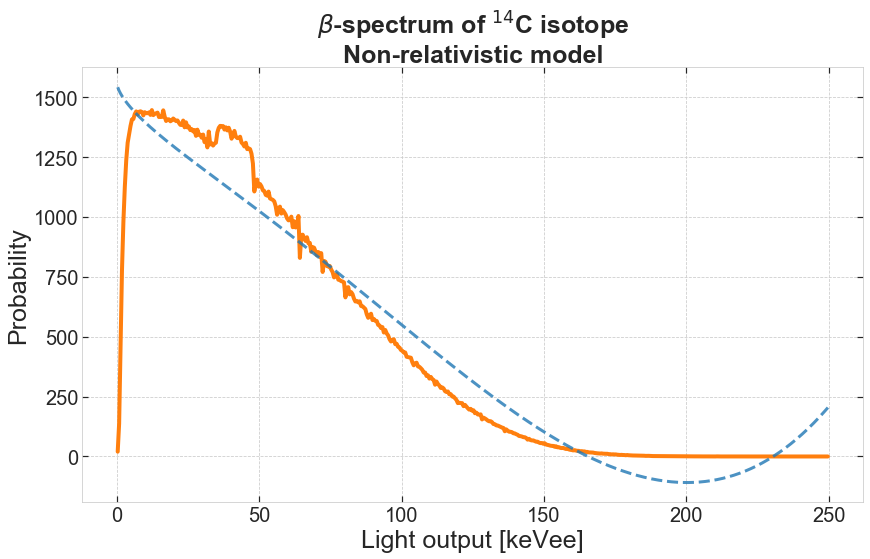

In [207]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14,nrows*8))

titlesize = 25
axislabelsize = 25
axisticksize = 20
legendsize = 20

axes.plot(data.index, data['mean'], label='Measured spectrum',
          lw=4, color='tab:orange', alpha=1.0)
axes.plot(energies, fit_non_relat(energies, *popt_nrel), label='Theoretical fitted',
          lw=3, color='tab:blue', ls='--', alpha=0.8)


axes.set_title('$\\beta$-spectrum of $^{14}$C isotope\nNon-relativistic model', fontsize=titlesize, fontweight='bold')
axes.set_xlabel('Light output [keVee]', fontsize=axislabelsize)
axes.set_ylabel('Probability', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(fontsize=legendsize)
plt.savefig(figsave_dir + 'non_relat_fit.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

### Non-relat with Fermi function

In [200]:
def fit_non_relat_fermi(E, p1, p2, p3, p4, p5):
    """
    Non-relativistic case. The Fermi function is the following:
    ``F = 2*pi*eta / (1 - e^(-2*pi*eta))``
    
    Where eta is p-dependent variable:
    ``eta = Z*e^2*c / (h/2pi * p)``
    Where `Z` is the beta-decayed nuclei's proton number, `e` is the
    elemental charge, `c` is the speed of light, `h` is the Plack
    constant, `p` is the momentum of the beta-particle.
    
    The momentum `p` could be evaluated by the known formula:
    ``p = sqrt(2*m*E)``
    Where `m` is the electron mass
    """
    
    # mass of electron [kg]
    m_e = 9.10938356e-31
    # light speed [m/s]
    c_light = 299792458
    
    # Something:
    #p = np.sqrt((E/c_light)**2 - (m_e * c_light)**2)
    # Non-realtivistic:
    p = np.sqrt(2*m_e*E)
    
    # Calculating Fermi function
    # --------------------------
    # eta = Z*e**2 * c / h_bar * p
    # e**2 * c / h_bar = 72974 J/(T^2 * m^3) (joules per tesla squared cubic meter)
    # eta = Z * 72974 / p
    # [eta] = (J/(T^2 * m^3)) / (kg * m/s)
    # [eta] = 1 / (s*(T^2 * m^2))
    # Since we measured 14C : Z = 6
    eta = Z * 72974 / p
    F = 2*np.pi*eta/(1 - np.e**(-2*np.pi*eta))

    return p1 + (p2 + p3 * E**(2/3) - p4 * E**(5/2) + p5 * E**(7/2)) * F

In [201]:
energies = data.index
popt_nrel, pcov_nrel = curve_fit(fit_non_relat_fermi, energies, data['mean'])
perr_nrel = np.sqrt(np.diag(pcov_nrel))
print(perr_nrel / popt_nrel * 100)

[ 3.08260974 -3.85067404 -4.97256434  3.76787365  3.53185446]


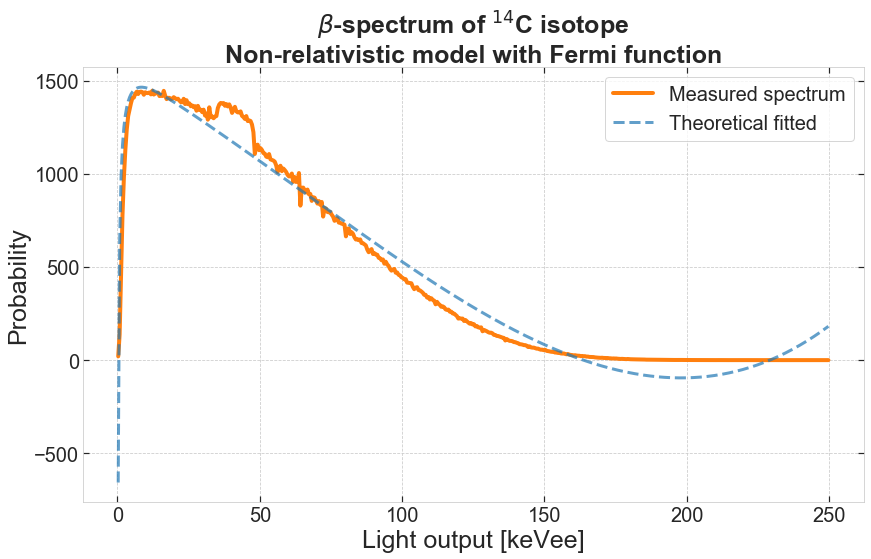

In [202]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14,nrows*8))

titlesize = 25
axislabelsize = 25
axisticksize = 20
legendsize = 20

axes.plot(data.index, data['mean'], label='Measured spectrum',
          lw=4, color='tab:orange', alpha=1.0)
axes.plot(energies, fit_non_relat_fermi(energies, *popt_nrel), label='Theoretical fitted',
          lw=3, color='tab:blue', ls='--', alpha=0.7)

axes.set_title('$\\beta$-spectrum of $^{14}$C isotope\nNon-relativistic model with Fermi function',
               fontsize=titlesize, fontweight='bold')
axes.set_xlabel('Light output [keVee]', fontsize=axislabelsize)
axes.set_ylabel('Probability', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(fontsize=legendsize)
plt.savefig(figsave_dir + 'non_relat_fermi_fit.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

In [203]:
def fit_relat_fermi(E, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10,
                    p11, p12, p13, p14, p15, p16, p17, p18, p19, p20, p21, p22, p23, Z, omega):
    """
    Relativistic case. The Fermi function is the following:
    ``F = 2*pi*eta / (1 - e^(-2*pi*eta))``
    
    Where eta is p-dependent variable:
    ``eta = Z*e^2*c / (h/2pi * p)``
    Where `Z` is the beta-decayed nuclei's proton number, `e` is the
    elemental charge, `c` is the speed of light, `h` is the Plack
    constant, `p` is the momentum of the beta-particle.
    
    The momentum `p` could be evaluated by the known formula:
    ``p = sqrt((E + m*c^2)^2 - (m*c^2)^2)``
    Where `m` is the electron mass
    """

    # Relativistic E_tot(E) and p(E)
    E_tot = m_e*c_light**2 + E
    p = np.sqrt((E_tot)**2 - m_e**2 * c_light**4)

    # Calculating Fermi function
    # --------------------------
    # eta = Z*e**2 * c / h_bar * p
    # e**2 * c / h_bar = 72974 J/(T^2 * m^3) (joules per tesla squared cubic meter)
    # eta = Z * 72974 / p
    # [eta] = (J/(T^2 * m^3)) / (kg * m/s)
    # [eta] = 1 / (s*(T^2 * m^2))
    # Since we measured 14C : Z = 6
    eta = Z * 72974 / p
    F = 2*np.pi*eta/(1 - np.e**(-2*np.pi*eta))
    
    return p1 + p2 * F * \
           (1/60 * c_light * np.sqrt(E * (2 * c_light**2 * m_e + p3 + p4 * E)) * \
            (-15 * c_light**8 * m_e**4 + 5 * c_light**6 * m_e**3 * (p5 + p6 * E - 3 * Q) + \
             c_light**4 * m_e**2 * E * (5 * Q - 2 * E * p7 + p8) * p8 + \
             2 * c_light**2 * m_e * E * (20 * Q**2 - p10 * 25 * Q * E + p11 + 9 * p12 * E**2) + \
             (30 * c_light**8 * m_e**4 * (c_light**2 * m_e + Q) * \
              np.log(np.sqrt(2 * c_light**2 * m_e + E * p13 + p14) + np.sqrt(E*p15 + p16)))/ \
             (np.sqrt(E*p17 + p18) * np.sqrt(2 * c_light**2 * m_e + E*p19 + p20)) + \
             p21 * 2 * E**2 * (10 * Q**2 - 15 * Q * E * p22 + Z * 6 * E**2 + omega)
            )
           ) + p23*F

In [208]:
energies = data.index
popt_rel, pcov_rel = curve_fit(fit_relat_fermi, energies, data['mean'])
perr_rel = np.sqrt(np.diag(pcov_rel))
print(perr_rel / popt_rel * 100)

[ inf -inf  inf  inf  inf  inf  inf  inf  inf -inf  inf -inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf -inf  inf  inf]


C:\Users\Lordpb\AppData\Roaming\Python\Python36\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


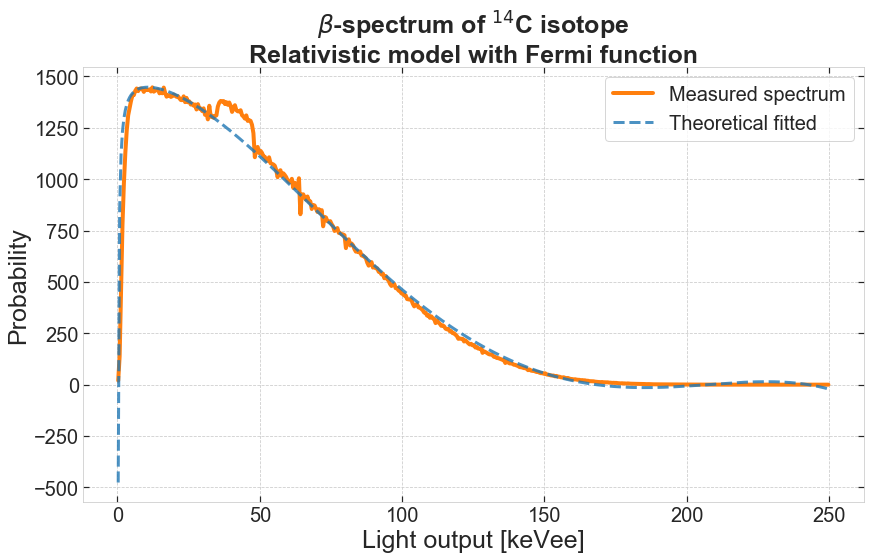

In [209]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14,nrows*8))

titlesize = 25
axislabelsize = 25
axisticksize = 20
legendsize = 20

axes.plot(data.index, data['mean'], label='Measured spectrum',
          lw=4, color='tab:orange', alpha=1.0)
axes.plot(energies, fit_relat_fermi(energies, *popt_rel), label='Theoretical fitted',
          lw=3, color='tab:blue', ls='--', alpha=0.8)

axes.set_title('$\\beta$-spectrum of $^{14}$C isotope\nRelativistic model with Fermi function',
               fontsize=titlesize, fontweight='bold')
axes.set_xlabel('Light output [keVee]', fontsize=axislabelsize)
axes.set_ylabel('Probability', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(fontsize=legendsize)
plt.savefig(figsave_dir + 'relat_fermi_fit.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()

In [210]:
def relat_fermi_fit2(E, p1, p2, p3, p4, p5, p6,
                     p7, p8, p9, p10, p11, p12, p13):
    
    # Relativistic E_tot(E) and p(E)
    E_tot = m_e*c_light**2 + E
    p = np.sqrt((E_tot)**2 - m_e**2 * c_light**4)

    # Calculating Fermi function
    # --------------------------
    # eta = Z*e**2 * c / h_bar * p
    # e**2 * c / h_bar = 72974 J/(T^2 * m^3) (joules per tesla squared cubic meter)
    # eta = Z * 72974 / p
    # [eta] = (J/(T^2 * m^3)) / (kg * m/s)
    # [eta] = 1 / (s*(T^2 * m^2))
    # Since we measured 14C : Z = 6
    eta = Z * 72974 / p
    F = 2*np.pi*eta/(1 - np.e**(-2*np.pi*eta))
    
    return (np.sqrt(p1 * E**2 + p2 * E + p3) *
           (p4 * E**3 + p5 * E**2 + p6 * E) -
           (p7 * np.arcsinh(p8 * np.sqrt(E) + p9) + p10)) * F * p11 + p12 * F + p13

In [211]:
energies = data.index
popt_rel, pcov_rel = curve_fit(relat_fermi_fit2, energies, data['mean'])
perr_rel = np.sqrt(np.diag(pcov_rel))
print(perr_rel / popt_rel * 100)

c:\users\lordpb\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


[            nan             nan             nan  6.01226383e+06
  6.01256780e+06  6.01279972e+06             nan -6.36936148e+02
  6.36927833e+02 -1.99344491e+07             nan -1.52902229e+03
  1.08329083e+02]


c:\users\lordpb\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


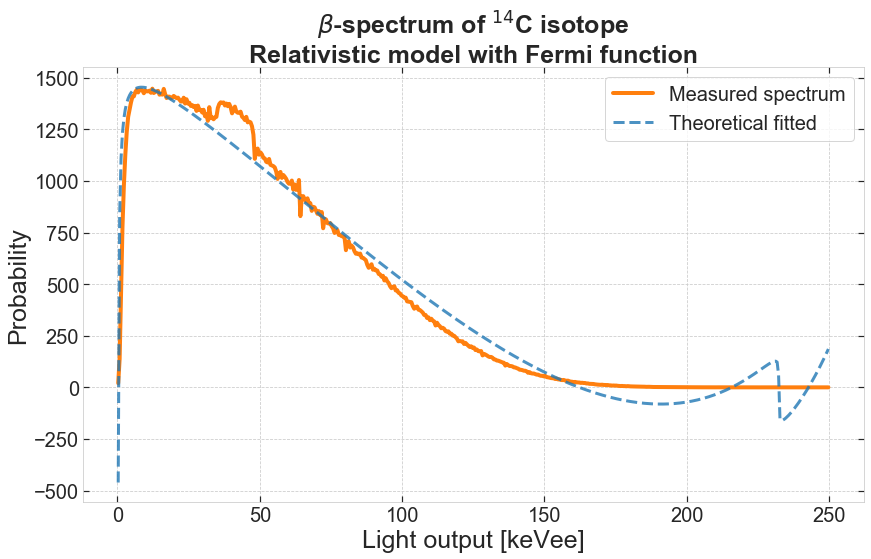

In [212]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*14,nrows*8))

titlesize = 25
axislabelsize = 25
axisticksize = 20
legendsize = 20

axes.plot(data.index, data['mean'], label='Measured spectrum',
          lw=4, color='tab:orange', alpha=1.0)
axes.plot(energies, relat_fermi_fit2(energies, *popt_rel), label='Theoretical fitted',
          lw=3, color='tab:blue', ls='--', alpha=0.8)

axes.set_title('$\\beta$-spectrum of $^{14}$C isotope\nRelativistic model with Fermi function',
               fontsize=titlesize, fontweight='bold')
axes.set_xlabel('Light output [keVee]', fontsize=axislabelsize)
axes.set_ylabel('Probability', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.legend(fontsize=legendsize)
plt.savefig(figsave_dir + 'relat_fermi_fit2.' + figsave_format,
            format=figsave_format,
            dpi=figsave_dpi,
            bbox_inches='tight')
plt.show()